In [14]:
# =============================================================================
# YellowBrick Visualization Experimentation Notebook
# Purpose: Test and customize YellowBrick visualizers (titles, legends, etc.)
# Data Loading: DuckDB SQL with DENSE_RANK label encoding
# =============================================================================

import duckdb
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [15]:
# =============================================================================
# Configuration
# =============================================================================
MINIO_HOST = "localhost"
MINIO_PORT = "9000"
MINIO_ENDPOINT = f"{MINIO_HOST}:{MINIO_PORT}"
MINIO_ACCESS_KEY = "minioadmin"
MINIO_SECRET_KEY = "minioadmin123"
PROJECT_NAME = "Transaction Fraud Detection"

DELTA_PATH = "s3://lakehouse/delta/transaction_fraud_detection"

# Feature definitions
TFD_NUMERICAL_FEATURES = ["amount", "account_age_days", "cvv_provided", "billing_address_match"]
TFD_CATEGORICAL_FEATURES = [
    "currency", "merchant_id", "payment_method", "product_category",
    "transaction_type", "browser", "os",
    "year", "month", "day", "hour", "minute", "second",
]
TFD_ALL_FEATURES = TFD_NUMERICAL_FEATURES + TFD_CATEGORICAL_FEATURES
TFD_CAT_FEATURE_INDICES = list(range(len(TFD_NUMERICAL_FEATURES), len(TFD_ALL_FEATURES)))

print(f"Project: {PROJECT_NAME}")
print(f"Features: {len(TFD_NUMERICAL_FEATURES)} numerical + {len(TFD_CATEGORICAL_FEATURES)} categorical")
print(f"Categorical indices: {TFD_CAT_FEATURE_INDICES}")

Project: Transaction Fraud Detection
Features: 4 numerical + 13 categorical
Categorical indices: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [16]:
# =============================================================================
# DuckDB Connection Setup
# =============================================================================
os.environ["AWS_EC2_METADATA_DISABLED"] = "true"

conn = duckdb.connect()
conn.execute("INSTALL delta; LOAD delta;")
conn.execute("INSTALL httpfs; LOAD httpfs;")

conn.execute(f"""
    CREATE SECRET minio_secret (
        TYPE S3,
        KEY_ID '{MINIO_ACCESS_KEY}',
        SECRET '{MINIO_SECRET_KEY}',
        REGION 'us-east-1',
        ENDPOINT '{MINIO_ENDPOINT}',
        URL_STYLE 'path',
        USE_SSL false
    );
""")
print("DuckDB connection ready with Delta extension")

DuckDB connection ready with Delta extension


In [17]:
# =============================================================================
# Load Data via DuckDB SQL (DENSE_RANK label encoding)
# =============================================================================
def load_data_duckdb_sql(delta_path: str, max_rows: int = None) -> pd.DataFrame:
    """Load data with SQL-based preprocessing. All features are numeric."""
    query = f"""
    SELECT
        -- Numerical features
        amount,
        account_age_days,
        CAST(cvv_provided AS INTEGER) AS cvv_provided,
        CAST(billing_address_match AS INTEGER) AS billing_address_match,

        -- Categorical features: Label encoded with DENSE_RANK() - 1
        DENSE_RANK() OVER (ORDER BY currency) - 1 AS currency,
        DENSE_RANK() OVER (ORDER BY merchant_id) - 1 AS merchant_id,
        DENSE_RANK() OVER (ORDER BY payment_method) - 1 AS payment_method,
        DENSE_RANK() OVER (ORDER BY product_category) - 1 AS product_category,
        DENSE_RANK() OVER (ORDER BY transaction_type) - 1 AS transaction_type,
        DENSE_RANK() OVER (ORDER BY json_extract_string(device_info, '$.browser')) - 1 AS browser,
        DENSE_RANK() OVER (ORDER BY json_extract_string(device_info, '$.os')) - 1 AS os,

        -- Timestamp components
        CAST(date_part('year', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS year,
        CAST(date_part('month', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS month,
        CAST(date_part('day', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS day,
        CAST(date_part('hour', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS hour,
        CAST(date_part('minute', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS minute,
        CAST(date_part('second', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS second,

        -- Target
        is_fraud
    FROM delta_scan('{delta_path}')
    """
    if max_rows:
        query += f" LIMIT {max_rows}"
    
    return conn.execute(query).df()

# Load data (use max_rows for faster experimentation)
df = load_data_duckdb_sql(DELTA_PATH, max_rows=50000)
print(f"Loaded {len(df)} rows, {len(df.columns)} columns")
print(f"Fraud rate: {df['is_fraud'].mean() * 100:.2f}%")
df.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loaded 50000 rows, 18 columns
Fraud rate: 0.95%


,amount,account_age_days,cvv_provided,billing_address_match,currency,merchant_id,payment_method,product_category,transaction_type,browser,os,year,month,day,hour,minute,second,is_fraud
0,200.71,1103,1,1,6,51,1,4,1,0,0,2026,1,15,6,54,28,0
1,477.58,1336,1,1,2,154,0,4,1,0,0,2026,1,15,19,57,43,0
2,250.82,1288,1,1,0,28,2,3,1,0,0,2026,1,18,17,20,3,0
3,205.92,24,1,1,3,124,2,4,1,0,0,2026,1,14,2,58,8,0
4,222.59,593,1,1,0,155,0,4,1,0,0,2026,1,19,15,13,32,0


In [18]:
# =============================================================================
# Train/Test Split
# =============================================================================
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Class info for YellowBrick
binary_classes = sorted(y.unique().tolist())
class_names = ["Non-Fraud", "Fraud"]
feature_names = X_train.columns.tolist()

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"Classes: {binary_classes} -> {class_names}")
print(f"Fraud rate: {y_train.mean() * 100:.2f}%")

X_train: (40000, 17), X_test: (10000, 17)
y_train: (40000,), y_test: (10000,)
Classes: [0, 1] -> ['Non-Fraud', 'Fraud']
Fraud rate: 0.95%


In [19]:
# =============================================================================
# Model Training (CatBoost - best for categorical features)
# =============================================================================
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    auto_class_weights='Balanced',  # Handle imbalanced data
    cat_features=TFD_CAT_FEATURE_INDICES,
    verbose=True,
    random_seed=42,
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20)
print(f"\nModel trained. Best iteration: {model.best_iteration_}")

0:	learn: 0.5973593	test: 0.5964520	best: 0.5964520 (0)	total: 418ms	remaining: 1m 23s
1:	learn: 0.5403522	test: 0.5378655	best: 0.5378655 (1)	total: 588ms	remaining: 58.2s
2:	learn: 0.4683579	test: 0.4671236	best: 0.4671236 (2)	total: 1.08s	remaining: 1m 11s
3:	learn: 0.4243758	test: 0.4227315	best: 0.4227315 (3)	total: 1.33s	remaining: 1m 5s
4:	learn: 0.3972867	test: 0.3939985	best: 0.3939985 (4)	total: 1.71s	remaining: 1m 6s
5:	learn: 0.3613993	test: 0.3580574	best: 0.3580574 (5)	total: 2.13s	remaining: 1m 8s
6:	learn: 0.3148838	test: 0.3093996	best: 0.3093996 (6)	total: 2.3s	remaining: 1m 3s
7:	learn: 0.2828396	test: 0.2757751	best: 0.2757751 (7)	total: 2.6s	remaining: 1m 2s
8:	learn: 0.2579796	test: 0.2513926	best: 0.2513926 (8)	total: 2.78s	remaining: 59.1s
9:	learn: 0.2346273	test: 0.2279992	best: 0.2279992 (9)	total: 3.04s	remaining: 57.8s
10:	learn: 0.2181308	test: 0.2108526	best: 0.2108526 (10)	total: 3.33s	remaining: 57.2s
11:	learn: 0.2013862	test: 0.1942766	best: 0.1942766

In [20]:
# =============================================================================
# YellowBrick Classification Visualizers - Fix for multiple plots
# =============================================================================
from yellowbrick.classifier import (
    ClassificationReport,
    ConfusionMatrix,
    ROCAUC,
    PrecisionRecallCurve,
)
from sklearn.base import BaseEstimator, ClassifierMixin

# Sklearn-compatible wrapper for CatBoost
class CatBoostWrapper(BaseEstimator, ClassifierMixin):
    _estimator_type = 'classifier'
    
    def __init__(self, model):
        self.model = model
        self.classes_ = np.array(model.classes_)
        self.feature_importances_ = np.array(model.get_feature_importance())
    
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        return self.model.predict(X).flatten()
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

wrapped_model = CatBoostWrapper(model)

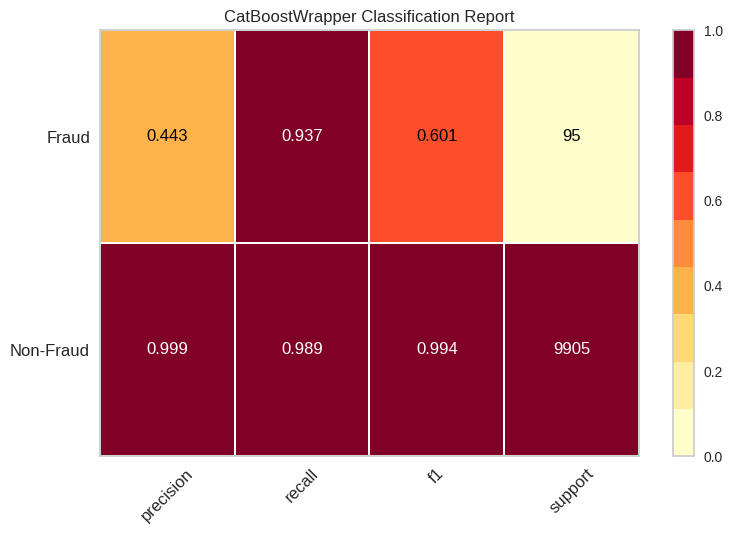

<Figure size 800x550 with 0 Axes>

In [21]:
# =============================================================================
# ClassificationReport - with plt.clf() fix
# =============================================================================
visualizer = ClassificationReport(
    wrapped_model,
    classes=class_names,
    support=True,
    is_fitted=True,
    force_model=True,
)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
visualizer.fig.savefig("classification_report.png", dpi=150, bbox_inches='tight')
plt.close(visualizer.fig)
plt.clf()

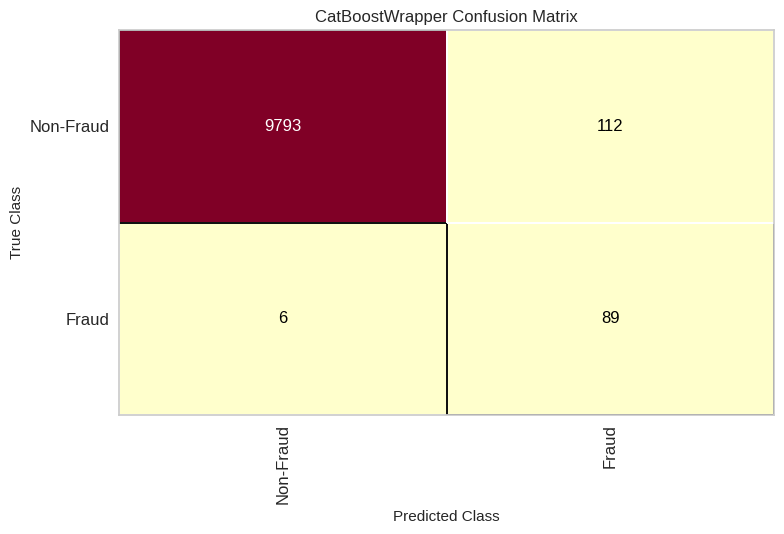

<Figure size 800x550 with 0 Axes>

In [22]:
# =============================================================================
# ConfusionMatrix - with plt.clf() fix
# =============================================================================
visualizer = ConfusionMatrix(
    wrapped_model,
    classes=class_names,
    is_fitted=True,
    force_model=True,
)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
visualizer.fig.savefig("confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.close(visualizer.fig)
plt.clf()

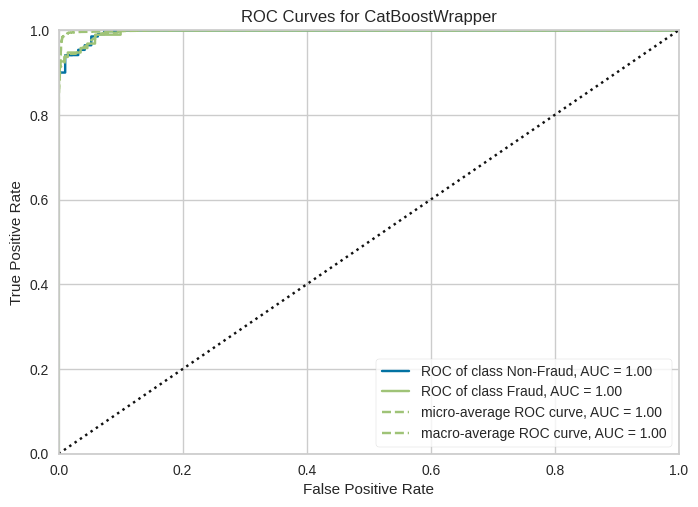

<Figure size 800x550 with 0 Axes>

In [23]:
# =============================================================================
# ROCAUC - with plt.clf() fix
# =============================================================================
visualizer = ROCAUC(
    wrapped_model,
    classes=class_names,
    is_fitted=True,
    force_model=True,
)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
visualizer.fig.savefig("roc_auc.png", dpi=150, bbox_inches='tight')
plt.close(visualizer.fig)
plt.clf()

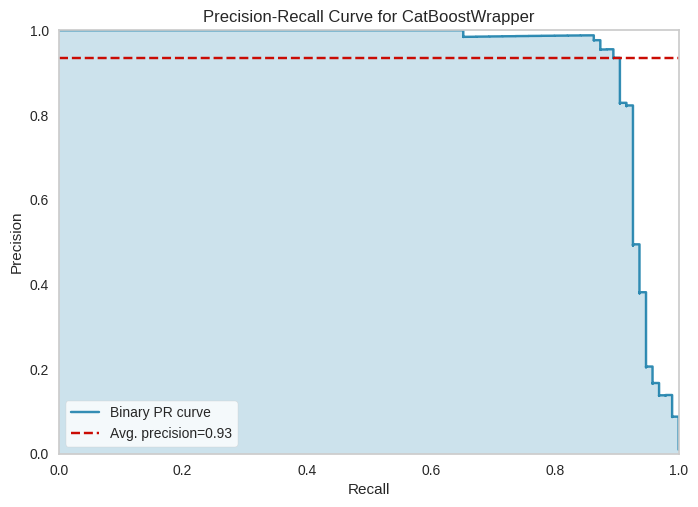

<Figure size 800x550 with 0 Axes>

In [24]:
# =============================================================================
# PrecisionRecallCurve - with plt.clf() fix
# =============================================================================
visualizer = PrecisionRecallCurve(
    wrapped_model,
    classes=class_names,
    is_fitted=True,
    force_model=True,
)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
visualizer.fig.savefig("precision_recall.png", dpi=150, bbox_inches='tight')
plt.close(visualizer.fig)
plt.clf()

In [25]:
# =============================================================================
# Summary: The FIX for multiple YellowBrick plots
# =============================================================================
# After each visualizer.show() and .savefig(), add:
#   plt.close(visualizer.fig)  # Close the specific figure
#   plt.clf()                   # Clear current figure state
#
# This prevents:
# - Overlapping plots
# - Corrupted PNG files
# - Memory leaks from unclosed figures
# =============================================================================

print("All classification visualizations saved:")
print("  - classification_report.png")
print("  - confusion_matrix.png")
print("  - roc_auc.png")
print("  - precision_recall.png")

All classification visualizations saved:
  - classification_report.png
  - confusion_matrix.png
  - roc_auc.png
  - precision_recall.png
